## **1단계: 라이브러리 다운로드 및 불러오기**

In [ ]:
# (그래프에 한글이 깨질경우) 아래 코드 실행 > '런타임: 세션 다시시작' 실행
!pip install matplotlib -U
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 라이브러리 불러오기: 데이터 핸들링
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# 라이브러리 불러오기: 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False  # plot "-" 부호 표기 설정

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# 라이브러리 불러오기: 경고 안내 무시
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#시각화 차트 옵션
def plot_option():
  plt.figure(figsize = (4, 3))
  plt.rc('font', family='NanumGothic')

---

## **1단계: 게임설명**
- **Cookie Cats 게임 설명**  
  - **분석 목적 :**  
    - **30gate/40gate 중에서 몇 번째 게이트에서 잠겨야 유저들의 리텐션이 높아지는지 분석**

  - **게임 규칙 :**
    - **타일을 연결되도록 보드를 클릭하여 3개를 연결(connect three)하는 스타일의 퍼즐 게임**

    - **특정 스테이지에 도달하면 잠겨지기 때문에 풀기위해 페북 친구에서 Keys 요청하거나 유료 결제하여 플레이하는 게임**


In [ ]:
## 데이터 변수별 의미
# userid:         유저별 고유번호
# version:        유저들의 플레이 배치 위치(즉, 실험 대조군)
# sum_gamerounds: 설치 후, 2주(14일) 간 플레이한 라운드 수
# retention_1:    유저가 설치 후 1일 만에 다시 플레이했는지 여부
# retention_7:    유저가 설치 후 7일 만에 다시 플레이했는지 여부

# ※ 유저가 게임을 설치할 때 무작위로 gate_30 혹은 gate_40에 배정

## **1단계: 데이터**
  - 데이터명: Cookie Cats 게임 데이터
  - 출처: 캐글의 오픈 데이터(https://www.kaggle.com/code/mursideyarkin/mobile-games-ab-testing-with-cookie-cats/data)

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/3. Research/[프로젝트] Cookie Cats게임 전략 분석/data/cookie_cats.csv')

print(df.shape)
df.tail()

(90189, 5)


,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


## **2단계: 탐색적 데이터 분석(EDA)**

In [ ]:
# 데이터 정보 확인

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [ ]:
# 데이터 결측치 확인

df.isnull().sum()

,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


In [ ]:
# 데이터 기초통계값 확인

df.describe(include='all').T
#df.describe().T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userid,90189.0000,NaN,NaN,NaN,4998412.2345,2883285.6077,116.0000,2512230.0000,4995815.0000,7496452.0000,9999861.0000
version,90189,2,gate_40,45489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_gamerounds,90189.0000,NaN,NaN,NaN,51.8725,195.0509,0.0000,5.0000,16.0000,51.0000,49854.0000
retention_1,90189,2,False,50036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retention_7,90189,2,False,73408,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## 데이터 변수의 고유값 수 확인
# retention_1, retention_7 변수 이진분류 完

uniques = df.nunique(axis=0)
print(uniques)

userid            90189
version               2
sum_gamerounds      942
retention_1           2
retention_7           2
dtype: int64


In [ ]:
## 데이터 변수의 고유값 수 확인
# 유저ID의 중복여부 없음 확인 完

df['userid'].nunique() == df['userid'].count()

True

In [ ]:
df.tail()

,userid,version,sum_gamerounds,retention_1,retention_7
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False
90188,9999861,gate_40,16,False,False


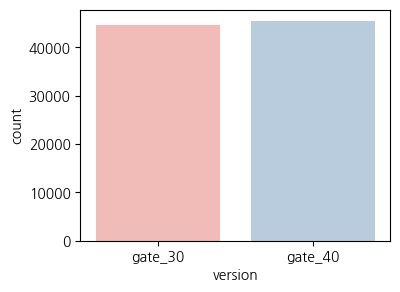

In [ ]:
## 데이터 시각화 탐색
# 두 그룹(gate_30, gate_40)이 균등하게 배분되어있는지 여부 확인 完

plot_option()
ax = sns.countplot(x = 'version', data = df, palette='Pastel1')

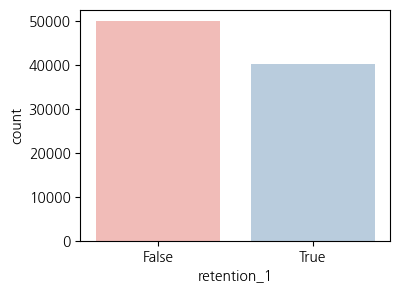

In [ ]:
## 데이터 시각화 탐색
# 유저가 설치 후 1일 만에 다시 플레이했는지 여부(True, False) 확인

plot_option()
ax = sns.countplot(x = 'retention_1', data = df, palette='Pastel1')

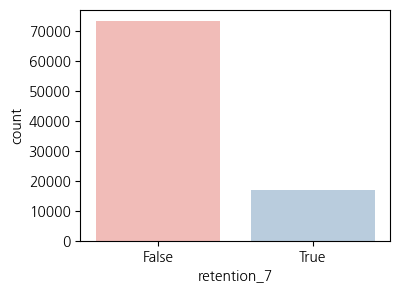

In [ ]:
## 데이터 시각화 탐색
# 유저가 설치 후 7일 만에 다시 플레이했는지 여부(True, False) 확인

plot_option()
ax = sns.countplot(x = 'retention_7', data = df, palette='Pastel1')

In [ ]:
#게이트 위치별 2주간 플레이 수/평균/분산/최소/중앙/최대 값 확인

df.groupby("version").sum_gamerounds.agg(["count", "mean", "std", "min", "median", "max"])

,count,mean,std,min,median,max
version,,,,,,
gate_30,44700,52.4563,256.7164,0,17.0000,49854
gate_40,45489,51.2988,103.2944,0,16.0000,2640


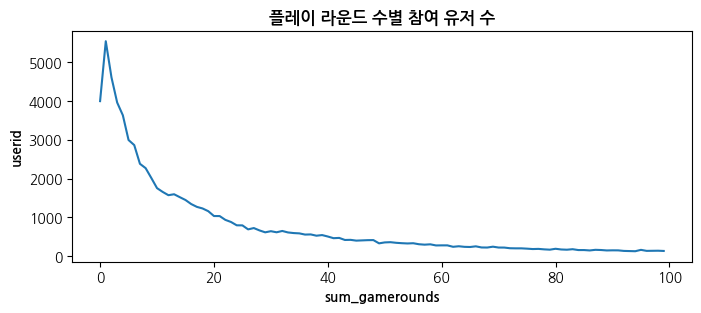

In [ ]:
## 데이터 시각화 탐색 : 2주간 플레이 라운드 수별 참여 플레이 수
# sum_gamerounds 변수의 최개값은 '49,854'이지만, describe()을 통해  '3Q(51)', 'Max(49854)'임을 확인하여 시각화 차트를 100까지 설정하여 도출

plot_option()
plot_ck = df.groupby("sum_gamerounds")["userid"].count()

plt.title('플레이 라운드 수별 참여 유저 수', fontweight="bold", size=12)
plt.xlabel('sum_gamerounds', fontweight="bold", size=10)
plt.ylabel('userid', fontweight="bold", size=10)

plot_ck[:100].plot(legend=False, figsize=(8,3))
plt.show()

In [ ]:
# 데이터 탐색 : 2주간 플레이 라운드 수별 참여 플레이 수

df.groupby('sum_gamerounds')['userid'].count()

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629
...,...
2294,1
2438,1
2640,1


In [ ]:
# 게임 설치 후, 100회 이하로 플레이한 유저를 시각화/표를 확인하였다.
# 이를 통해, 한번도 플레이하지 않은 유저가 3,994명이고, 1~3회 플레이한 유저는 14,102명임을 확인했다(즉, 이탈유저가 전체 20% 수준)

# 상기 결과를 통해 이탈사유를 아래와 같이 예측해봤다.
# 1. 플레이어가 게임 구성 요소(메커니즘, 디자인, 음악, 스토리)가 마음에 들지 않아서 이탈
# 2. 레벨이 올라갈수록 난이도가 높아져 흥미를 잃어 이탈
# 3. 지나친 결제 유도로 인한 거부감으로 이탈
# 4. 실제 게임이 광고와의 차이로 이탈

----

In [ ]:
# 이어서, 상대적으로 낮은 플레이 횟수의 유저들이 많은 이탈율을 보인다는 것을 확인하면서 생존율을 높일 방법 고민 必

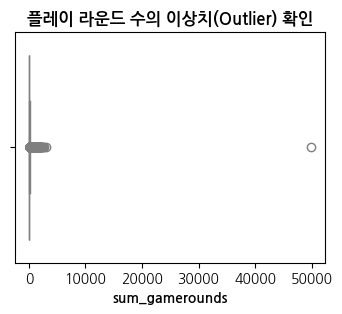

In [ ]:
plot_option()
plt.title('플레이 라운드 수의 이상치(Outlier) 확인', fontweight="bold", size=12)
plt.xlabel('sum_gamerounds', fontweight="bold", size=10)

sns.boxplot(data=df, x='sum_gamerounds', palette='Pastel1')
plt.show()

In [ ]:
# 유저들의 2주간 플레이 라운드 수를 확인해본 결과 '49,854회' 플레이를 확인했으며, 이는 해당 변수의 전체 분포 대비 극단치 값이라 생각되어 이상치라 판단
# 하여, 해당 변수의 요소값은 불필요한 데이터라 생각되어 제거

---

In [ ]:
# 각 플레이 위치별 리텐션 정도 비교
ck_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
ck_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.4482,0.1902,2344795
gate_40,45489,0.4423,0.1820,2333530


In [ ]:
# 위 표를 통해 게이트(gate)별 리텐션을 비교배봤을 때 30gate의 1일 리텐션 0.59%(0.0059), 7일 리텐션 0.82%(0.0082) 차이로 높은 것을 확인했다.

---

<Figure size 400x300 with 0 Axes>

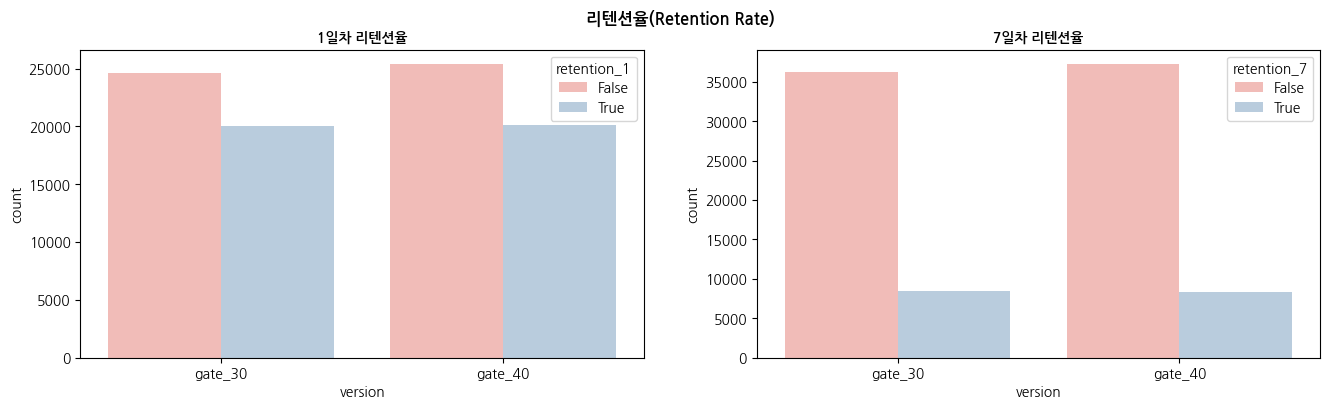

In [ ]:
plot_option()

fig, axes = plt.subplots(1, 2, figsize=(16,4))
sns.countplot(x = 'version', data = df, hue = 'retention_1', palette='Pastel1', ax=axes[0])
sns.countplot(x = 'version', data = df, hue = 'retention_7', palette='Pastel1', ax=axes[1])

plt.suptitle('리텐션율(Retention Rate)', fontweight="bold", size=12)
axes[0].set_title('1일차 리텐션율', fontweight="bold", size=10)
axes[1].set_title('7일차 리텐션율', fontweight="bold", size=10)

plt.show()

In [ ]:
## 위 차트를 통해 1일/7일차 리텐션율을 확인해봤을 때...

## 1일 리텐션
# gate_30 : 1일 만에 게임에 복귀한 유저는 20,034명, 복귀하지 않은 유저 24,666명
# gate_40 : 1일 만에 게임에 복귀한 유저는 20,119명, 복귀하지 않은 유저 25,370명

## 7일 리텐션
# gate_30 : 7일 만에 게임에 복귀한 유저는 8,502명, 복귀하지 않은 유저는 36,198명.
# gate_40 : 7일 만에 게임에 복귀한 유저는 8,279명, 복귀하지 않은 유저는 37,210명

In [ ]:
# 게임 설치 후, 7일 뒤에 재접속한 유저를 확인했을 때 재접속하지 않은 유저가 접속한 유저보다 압도적으로 많은 것을 확인했다.
# 여기서, 7일 뒤에 재접속 수가 줄어드는 것은 자연스러운 현상이라 생각되며, 재접속 자체에 대한 고객 액션의 존재는 게임에 대한 유저 흥미가 존재한다는 것을 확인

# 하지만 위 시각화 탐색을 통해 30gate/40gate 중 어느 게이트에서 잠겨야 리텐션율이 높아지는지 여부를 단정하기 어려워 가설검정 수행을 통한 진단이 필요하다 판단
# (즉, 게이트별 리텐션율을 보면 30gate이 좋다고 판단되지만 단순 평균 비교 결과로써 더 높다고 판단하기 모호하다는 의미)

---

In [ ]:
## 탐색적 데이터 분석(EDA) 과정 요약

# 1. 데이터 정보 확인 및 결측치(null) 없음 확인
# 2. 리텐션 변수의 이진값(True/False) 상태 확인
# 3. 중복된 항목/사용자가 없음을 확인
# 4. 두 게이트(gate_30, gate_40)는 비교적 균형을 이루었음을 확인
# 5. 데이터 전처리를 수행할 부분이 적어 어느정도 정제된 데이터셋이란 사실 확인
# 6. 30gate의 1일/7일차 리텐션율은 모두 높지만, 단순 평균 비교 결과로써 30gate가 더 높은 리텐션이라 판단하기 모호함 확인

----

## **3단계: 데이터 전처리**

In [ ]:
## 이상치 제거
# 상기의 탐색적 분석 과정에서 확인한 이상치 값 제거

df = df[df['sum_gamerounds'] != 49854]

In [ ]:
# 전처리 결과 확인

df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
userid,90188.0000,NaN,NaN,NaN,4998396.7979,2883297.8659,116.0000,2512211.2500,4995804.0000,7496460.7500,9999861.0000
version,90188,2,gate_40,45489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_gamerounds,90188.0000,NaN,NaN,NaN,51.3203,102.6827,0.0000,5.0000,16.0000,51.0000,2961.0000
retention_1,90188,2,False,50035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
retention_7,90188,2,False,73408,NaN,NaN,NaN,NaN,NaN,NaN,NaN


___

## **4단계: 가설 검정**
- **카이제곱 검정(Chi-Squared Test)**
  - 정의 : 두 개의 범주형 변수 간 연관성을 검정하는 방법
    -  예시 : ①성별에 따른 정당 지지율 비교 / ②스테이지에 따른 리텐션율 비교 등
  - 가정(조건) :
    - 독립성 가정을 만족한다(1명의 대상에게서 1개의 결과 값을 얻어야 한다.)
    - 기대 빈도가 5 미만인 셀은 전체 셀의 20% 미만이어야 한다.
  - 가설설정 :
    - 귀무가설(H0): 두 변수는 서로 독립적이다(즉, 연관이 없다).
    - 대립가설(H1): 두 변수는 서로 독립적이지 않다(즉, 연관이 있다).


  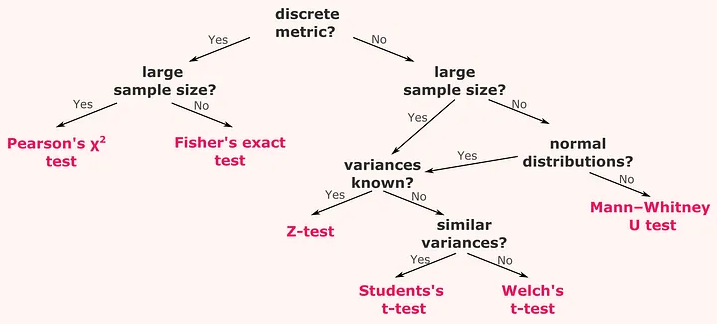

In [ ]:
# 1일/7일차 리텐션 변수는 모두 bool형태 값(True/False)을 가지는 범주형 변수이고, 9만개(90,000개)가 넘는 대용량 데이터이므로 카이제곱 검정을 수행한다.

---

### **4.1. 1일차 리텐션의 검정**

In [ ]:
## 가설설정 :
# 귀무가설(H0) : "게이트에 따라 리텐션별 유의미한 차이가 없다(즉, 변화없음)"
# 대립가설(H1) : "게이트에 따라 리텐션별 유의미한 차이가 있다(즉, 변화있음)"

day_1 = df.groupby(['version','retention_1']).size()
day_1

version  retention_1
gate_30  False          24665
         True           20034
gate_40  False          25370
         True           20119
dtype: int64

In [ ]:
new_cookie1 = pd.DataFrame(data=[[20034,20119],[24666,25370]],
                          index=["True","False"],
                          columns=["gate_30","gate_40"])
new_cookie1

,gate_30,gate_40
True,20034,20119
False,24666,25370


In [ ]:
# 피어슨 카이제곱 검정
chi2_val, p_val = chi2_contingency(new_cookie1.values, correction=False)[:2]

# 유의수준 설정
alpha=0.05

# 검정 결과 산출
print("피어슨 카이제곱 검정(Pearson's chi-squared test):")
print(f"- χ2 value: {chi2_val:.3f}")
print(f"- p-value: {p_val}")

# 결론
{'H0 is rejected' if p_val <= alpha else 'H0 is accepted'}

피어슨 카이제곱 검정(Pearson's chi-squared test):
- χ2 value: 3.183
- p-value: 0.07440965529692188


{'H0 is accepted'}

In [ ]:
# 1일차 리텐션은 유의수준 0.05 보다 큰 값을 산출하여 귀무가설을 채택했다.
# 이를 통해, 30gate와 40gate의 리텐션은 특별한 차이가 없다는 것을 확인했다.

---

### **4.1. 7일차 리텐션의 검정**

In [ ]:
day_7 = df.groupby(['version','retention_7']).size()
day_7

version  retention_7
gate_30  False          36198
         True            8501
gate_40  False          37210
         True            8279
dtype: int64

In [ ]:
new_cookie2 = pd.DataFrame(data=[[8502,8279],[36198,37210]],
                           index=["True","False"],
                           columns=["gate_30","gate_40"])
new_cookie2

,gate_30,gate_40
True,8502,8279
False,36198,37210


In [ ]:
# 피어슨 카이제곱 검정
chi2_val, p_val = chi2_contingency(new_cookie2.values, correction=False)[:2]

# 유의수준 설정
alpha=0.05

# 검정 결과 산출
print("피어슨 카이제곱 검정(Pearson's chi-squared test):")
print(f"- χ2 value: {chi2_val:.3f}")
print(f"- p-value: {p_val}")

# 결론
{'H0 is rejected' if p_val <= alpha else 'H0 is accepted'}

피어슨 카이제곱 검정(Pearson's chi-squared test):
- χ2 value: 10.013
- p-value: 0.0015542499756142805


{'H0 is rejected'}

In [ ]:
# 7일차 리텐션은 유의수준 0.05 보다 작은 값을 산출하여 귀무가설을 기각했다.
# 이를 통해, 30gate와 40gate의 리텐션은 유의미한 차이가 있다는 것을 확인했다.

___

### **4.2. 부트스트랩**

In [ ]:
# 특정 분포를 가정하기 어려울 때 수행되는 비모수적(non-para-metric) 방법 중, 두 그룹을 비교 분석하고자 부트스트랩(Bootstrap) 방법 활용
# 여기서, 부트스트랩이란, 복원추출(하나를 뽑고 다시 그걸 넣어서 다시 뽑는 방법)을 통해 표본을 재생성하는 방법

  ### **4.2. 부트스트랩 : 1일차 리텐션**

In [ ]:
## 1일차 리텐션율
# 임의 1,000개 데이터를 복원추출하여 샘플링

boot_1d = []

for i in range(1000):
    boot_1d.append(df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean())


boot_1d = pd.DataFrame(boot_1d).reset_index().drop(columns=['index'])
boot_1d.head()

version,gate_30,gate_40
0,0.4499,0.4409
1,0.4494,0.4422
2,0.4458,0.4397
3,0.4471,0.4443
4,0.4493,0.4395


<Figure size 400x300 with 0 Axes>

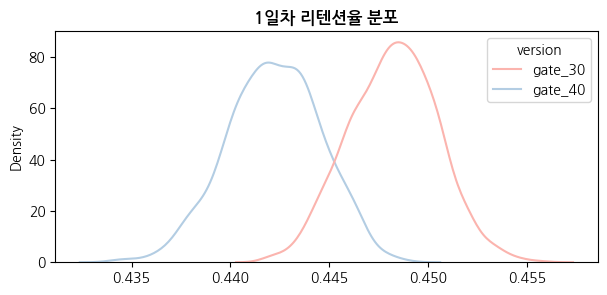

In [ ]:
## 1일차 리텐션율
# 임의 추출한 데이터 분포 시각화

plot_option()
fig, ax = plt.subplots(figsize=(7,3))

sns.kdeplot(data=boot_1d, ax=ax, palette='Pastel1')
ax.set_title('1일차 리텐션율 분포', fontweight="bold", size=12)
plt.show()

___

  ### **4.2. 부트스트랩: 7일차 리텐션**

In [ ]:
## 7일차 리텐션율
# 임의 1,000개 데이터를 복원추출하여 샘플링

boot_7d = []

for i in range(1000):
    boot_7d.append(df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean())

boot_7d = pd.DataFrame(boot_7d).reset_index().drop(columns=['index'])
boot_7d.head()

version,gate_30,gate_40
0,0.1882,0.1810
1,0.1896,0.1845
2,0.1905,0.1827
3,0.1886,0.1845
4,0.1921,0.1793


<Figure size 400x300 with 0 Axes>

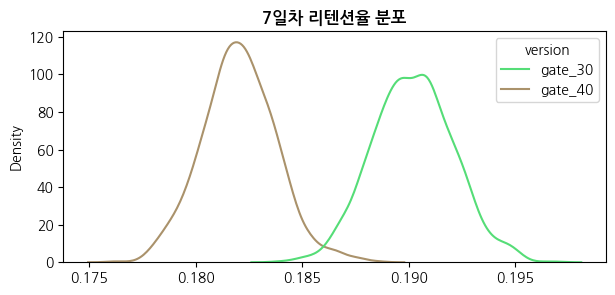

In [ ]:
## 7일차 리텐션율
# 임의 추출한 데이터 분포 시각화

plot_option()
fig, ax = plt.subplots(figsize=(7,3))

sns.kdeplot(data=boot_7d, ax=ax, palette = 'terrain')
ax.set_title('7일차 리텐션율 분포', fontweight="bold", size=12)
plt.show()

---

In [ ]:
boot_1d

version,gate_30,gate_40,diff
0,0.4499,0.4409,2.0368
1,0.4494,0.4422,1.6192
2,0.4458,0.4397,1.3855
3,0.4471,0.4443,0.6484
4,0.4493,0.4395,2.2215
...,...,...,...
995,0.4468,0.4368,2.2822
996,0.4517,0.4444,1.6249
997,0.4481,0.4424,1.2869
998,0.4509,0.4415,2.1424


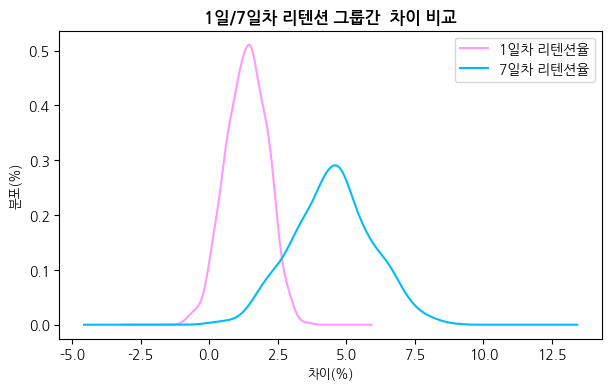

In [ ]:
## 데이터 시각화 탐색

# 1일/7일차 리텐션율의 게이트(gate) 30과 40의 차이를 백분율 형태로 산출
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# 그룹간 차이를 시각화하여 비교
fig, ax1 = plt.subplots(1, 1,figsize=(7,4))
boot_1d['diff'].plot.kde(ax=ax1, c="#ff98ff", label = "1일차 리텐션율")
boot_7d['diff'].plot.kde(ax=ax1, c="#00bbff", label = "7일차 리텐션율")

ax1.set_xlabel("차이(%)",size=9)
ax1.set_ylabel("분포(%)",size=9)
ax1.set_title("1일/7일차 리텐션 그룹간  차이 비교", fontweight="bold", size=12)
plt.legend()
plt.show()

In [ ]:
# 위 그래프를 보면, 1일차 리텐션율이 약 1~2% 차이의 높은 분포, 7일차 리텐션율은 2~5% 차이의 비교적 완만한 분포를 나타내는 것을 확인했다.
# 또한, 분포가 대체적으로 0% 이상으로 30게이트가 더 유리하다는 것을 확인했다.

# 참고) diff값이 0을 초과하면 '30게이트가 좋다' / diff값이 0 미만이면 '40게이트가 좋다'라고 표현

___

In [ ]:
## 30게이트일 때

#1일차 리텐션이 더 높을 확률 확인
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])
print(f"1. Gate 30일 때 1일 리텐션이 더 높을 확률: {round((prob_1)*100,3)}% ")

#7일차 리텐션이 더 높을 확률 확인
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])
print(f"2. Gate 30일 때 7일 리텐션이 더 높을 확률: {(prob_7)*100}% ")

1. Gate 30일 때 1일 리텐션이 더 높을 확률: 96.9% 
2. Gate 30일 때 7일 리텐션이 더 높을 확률: 99.9% 


In [ ]:
# 30게이트일 때 1일/7일차 리텐션을 계산했을 때 1일차 리텐션이 96%이고, 7일차 리텐션이 99%임을 확인했다.

## **5단계: 결론**

In [ ]:
# 카이제곱 검정을 통해 1일차 리텐션은 게이트에 따른 통계적 유의미한 차이가 없다는 것을 확인했다.
# 이는 게임 설치 후, 1일차에는 게이트 30 혹은 40에 도달할 확률이 낮기 때문일 것이라 예상된다.

# 반면, 7일차 리텐션의 카이제곱 검정과 부트스트랩 검정 결과 모두 통계적으로 유의미한 차이가 있다는 것을 확인했다.
# 이에, 게이트 30에서 잠긴 유저는 게이트 40에서 잠긴 유저 보다 7일 리텐션이 높은 것이라 예상된다.

# 따라서, "게이트를 높이는 것은 권장하지 않고 기존 그대로 게이트 30을 유지하는 것이 적절하다 판단된다.""

---